In [1]:
from pystac_client import Client
from pystac.extensions.eo import EOExtension as eo
import planetary_computer as pc
import geopandas as gpd
import h3
import pandas as pd

import rasterio
from rasterio import windows
from rasterio import features
from rasterio import warp
import rasterio.mask
from rasterio.enums import Resampling
from rasterio.merge import merge

from scipy import stats as st

import numpy as np
from PIL import Image

import matplotlib.pyplot as plt

from shapely.geometry import Point

import signal
import time

from tqdm import tqdm

import os
import sys
module_path = os.path.abspath(os.path.join('../../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup

/home/edgaregurrola/anaconda3/envs/odc/lib/python3.10/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.10.3-CAPI-1.16.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


2023-02-21 18:40:03 Configured OSMnx 1.1.2
2023-02-21 18:40:03 HTTP response caching is on


In [2]:
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

## Download data

### Municipality GeoDataFrame

(3, 6)


<AxesSubplot: >

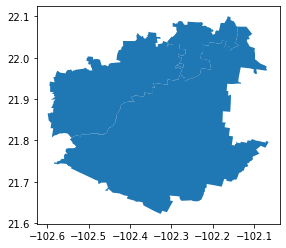

In [3]:
city = 'Aguascalientes'
query = f"SELECT * FROM metropolis.metro_gdf WHERE \"city\" LIKE \'{city}\'"
mun_gdf = aup.gdf_from_query(query, geometry_col='geometry')
print(mun_gdf.shape)
mun_gdf.plot()

### Hex-bins GeoDataFrame

(309, 2)


<AxesSubplot: >

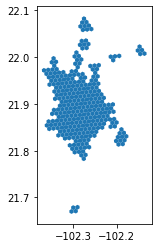

In [4]:
mpos = list(mun_gdf.CVEGEO.unique())

hex_ageb = gpd.GeoDataFrame()

schema = 'censo'
folder = 'hex_bins_pop_2020'

for m in mpos:
    query = f"SELECT hex_id_8,geometry FROM {schema}.{folder} WHERE \"CVEGEO\" LIKE \'{m}%%\'"
    hex_ageb = pd.concat([hex_ageb, 
                          aup.gdf_from_query(query, geometry_col='geometry')], 
                         ignore_index = True, axis = 0)

print(hex_ageb.shape)
hex_ageb.plot()

In [5]:
hex_ageb.head(2)

,hex_id_8,geometry
0,88498e36dbfffff,"POLYGON ((-102.34777 21.92336, -102.34267 21.9..."
1,88498e36d5fffff,"POLYGON ((-102.32839 21.92505, -102.32329 21.9..."


Create hexagons for area with population at different resolutions

In [6]:
hex_gdf = hex_ageb.copy()
hex_gdf.rename(columns={'hex_id_8':'hex_id'}, inplace=True)
hex_gdf['res'] = 8

for r in range(9,12):
    
    hex_tmp = aup.create_hexgrid(hex_ageb, r)
    hex_tmp.rename(columns={f'hex_id_{r}':'hex_id'}, inplace=True)
    hex_tmp['res'] = r
    
    hex_gdf = pd.concat([hex_gdf, hex_tmp], 
        ignore_index = True, axis = 0)
    
    del hex_tmp

In [7]:
print(hex_gdf.shape)
hex_gdf.head(2)

(123600, 3)


,hex_id,geometry,res
0,88498e36dbfffff,"POLYGON ((-102.34777 21.92336, -102.34267 21.9...",8
1,88498e36d5fffff,"POLYGON ((-102.32839 21.92505, -102.32329 21.9...",8


## Access raster data

### Create boundaries for imagery download

In [8]:
# Reads mun_gdf GeoDataFrame as polygon
poly = hex_gdf.loc[hex_gdf.res==8].geometry
# Extracts coordinates from polygon as DataFrame
coord_val = poly.bounds
# Gets coordinates for bounding box
n = coord_val.maxy.max()
s = coord_val.miny.min()
e = coord_val.maxx.max()
w = coord_val.minx.min()

#### Generate polygon dictionary

In [9]:
area_of_interest = {
    "type": "Polygon",
    "coordinates": [
        [
            [e, s],
            [w, s],
            [w, n],
            [e, n],
            [e, s],
        ]
    ],
}

### Define time period for imagery

Since the api is limited to a max of 100 images, dates are divided in periods of 3 months.

In [10]:
time_of_interest = ["2020-01-01/2020-03-31","2020-04-01/2020-06-30",
                    "2020-07-01/2020-09-30","2020-10-01/2020-12-31",
                    "2021-01-01/2021-03-31","2021-04-01/2021-06-30",
                    "2021-07-01/2021-09-30","2021-10-01/2021-12-31",
                    "2022-01-01/2022-03-31","2022-04-01/2022-06-30",
                    "2022-07-01/2022-09-30","2022-10-01/2022-12-31",
                   ]

### Identify imagery

This section identifies satellite imagery that meets the requeirments for the Satellite (sentinel-2-l2a), area_of_interest, time_of_interest and limit for cloud cover (10%).

In [11]:
catalog = Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")

items = []

for t in time_of_interest:
    search = catalog.search(
        collections=["sentinel-2-l2a"],
        intersects=area_of_interest,
        datetime=t,
        query={"eo:cloud_cover": {"lt": 10}},
    )

    # Check how many items were returned
    items.extend(list(search.get_items()))
print(f"Returned {len(items)} Items")

Returned 508 Items


## Raster data gathering and filter

### Gather links for imagery bands

Identify download links for Near Infrared (nir) and SWIR bands for each date that meets the requierments.

In [12]:
def find_asset_by_band_common_name(item, common_name):
    for asset in item.assets.values():
        asset_bands = eo.ext(asset).bands
        if asset_bands and asset_bands[0].common_name == common_name:
            return asset
    raise KeyError(f"{common_name} band not found")

Bands to analyze

In [13]:
band_name_list = ['red','nir']

In [14]:
def link_dict(band_name_list):
    
    assets_hrefs = {}

    for i in items:
        if i.datetime.date() in list(assets_hrefs.keys()):
            for b in band_name_list:
                assets_hrefs[i.datetime.date()][b].append(pc.sign(find_asset_by_band_common_name(i,b).href))
        else:
            assets_hrefs[i.datetime.date()] = {}
            for b in band_name_list:
                assets_hrefs[i.datetime.date()].update({b:[]})
                assets_hrefs[i.datetime.date()][b].append(pc.sign(find_asset_by_band_common_name(i,b).href))
                
    return assets_hrefs

In [15]:
assets_hrefs = link_dict(band_name_list)

Remove dates without insuficcient data

In [16]:
def filter_links(assets_hrefs, band_name_list):
    max_links_len = st.mode(np.array([len(x[band_name_list[0]]) for x in list(assets_hrefs.values())]))[0][0]
    
    # iterate and remove dates without sufficient data
    for k_date in list(assets_hrefs.keys()):
        # gather data from first band in dictionary - the max value should be the same in all bands
        k_band = list(assets_hrefs[k_date].keys())[0]
        # compare len of that band to max
        if len(assets_hrefs[k_date][k_band]) != max_links_len:
            # if len is less it indicates that is missing data
            # remove date with missing data
            assets_hrefs.pop(k_date)
    
    return assets_hrefs, max_links_len

In [17]:
assets_hrefs, m = filter_links(assets_hrefs, band_name_list)

Filter data by month

In [18]:
def df_date_links(assets_hrefs, start_date, periods):
    # dictionary to dataframe
    df_dates = pd.DataFrame.from_dict(assets_hrefs, orient='Index').reset_index().rename(columns={'index':'date'})
    df_dates['date'] = pd.to_datetime(df_dates['date']).dt.date
    df_dates['year'] = df_dates.apply(lambda row: row['date'].year, axis=1)
    df_dates['month'] = df_dates.apply(lambda row: row['date'].month, axis=1)
    
    df_dates_filtered = pd.DataFrame()
    
    # keep only one data point by month
    for y in df_dates['year'].unique():
        for m in df_dates.loc[df_dates['year']==y,'month'].unique():
            df_dates_filtered = pd.concat([df_dates_filtered,
                                         df_dates.loc[(df_dates['year']==y)&
                                                      (df_dates['month']==m)].sample(1)],
                                          ignore_index=True)
    
    # create full range time dataframe
    df_tmp_dates = pd.DataFrame() # temporary date dataframe
    df_tmp_dates['date'] = pd.date_range(start = start_date,   
                               periods = periods,   # there are 30 periods because range from satelite img goes from 01-01-2020 - 30-06-2022
                               freq = "M") # create date range
    # extract year and month
    df_tmp_dates['year'] = df_tmp_dates.apply(lambda row: row['date'].year, axis=1)
    df_tmp_dates['month'] = df_tmp_dates.apply(lambda row: row['date'].month, axis=1)

    # remove date column for merge
    df_tmp_dates.drop(columns=['date'], inplace=True)

    df_complete_dates = df_tmp_dates.merge(df_dates_filtered, left_on=['year','month'],
                                          right_on=['year','month'], how='left')

    # remove date 
    df_complete_dates.drop(columns='date', inplace=True)
    df_complete_dates.sort_values(by=['year','month'], inplace=True)
    
    missing_months = df_complete_dates.nir.isna().sum()
    
    return df_complete_dates, missing_months

In [19]:
df_complete_dates, missing_months = df_date_links(assets_hrefs, "2020-01-01", 36)

In [20]:
print(df_complete_dates.shape)
df_complete_dates.head(4)

(36, 4)


,year,month,red,nir
0,2020,1,[https://sentinel2l2a01.blob.core.windows.net/...,[https://sentinel2l2a01.blob.core.windows.net/...
1,2020,2,[https://sentinel2l2a01.blob.core.windows.net/...,[https://sentinel2l2a01.blob.core.windows.net/...
2,2020,3,[https://sentinel2l2a01.blob.core.windows.net/...,[https://sentinel2l2a01.blob.core.windows.net/...
3,2020,4,[https://sentinel2l2a01.blob.core.windows.net/...,[https://sentinel2l2a01.blob.core.windows.net/...


In [26]:
def gather_links():
    # gather links
    assets_hrefs = aup.link_dict(band_name_list, items)
    # filters for dates with full data
    assets_hrefs, max_links = aup.filter_links(assets_hrefs, band_name_list)
    aup.log(f'{max_links} rasters by time analysis')
    # create complete dates DataFrame
    df_complete_dates, missing_months = aup.df_date_links(assets_hrefs, "2020-01-01", time_range)
    return df_complete_dates,missing_months

## Create NDMI files

In [21]:
def mosaic_raster(raster_asset_list, tmp_dir='tmp/', upscale=False):
    src_files_to_mosaic = []

    for assets in raster_asset_list:
        src = rasterio.open(assets)
        src_files_to_mosaic.append(src)
        
    mosaic, out_trans = merge(src_files_to_mosaic) # mosaic raster
    
    meta = src.meta
    
    if upscale:
        # save raster
        out_meta = src.meta

        out_meta.update({"driver": "GTiff",
                         "dtype": 'float32',
                         "height": mosaic.shape[1],
                         "width": mosaic.shape[2],
                         "transform": out_trans})
        # write raster
        with rasterio.open(tmp_dir+"mosaic_upscale.tif", "w", **out_meta) as dest:
            dest.write(mosaic)

            dest.close()
        # read and upscale
        with rasterio.open(tmp_dir+"mosaic_upscale.tif", "r") as ds:

            upscale_factor = 1/2

            mosaic = ds.read(
                        out_shape=(
                            ds.count,
                            int(ds.height * upscale_factor),
                            int(ds.width * upscale_factor)
                        ),
                        resampling=Resampling.bilinear
                    )

        ds.close()
    src.close()
    
    return mosaic, out_trans, meta

In [22]:
def time_limit(seconds):
    def signal_handler(signum, frame):
        raise TimeoutException("Timed out!")
    signal.signal(signal.SIGALRM, signal_handler)
    signal.alarm(seconds)
    try:
        yield
    finally:
        signal.alarm(0)

In [32]:
df_len = df_complete_dates.copy()

index_analysis = 'ndvi'
tmp_dir = f'../../data/processed/tmp_{index_analysis}/'
time_range = 36

aup.log('\n Starting raster analysis')

for i in tqdm(range(len(df_len)), position=0, leave=True):

    if type(df_len.iloc[i].nir)!=list:
        continue

    # gather month and year from df to save ndmi
    month_ = df_complete_dates.iloc[i]['month']
    year_ = df_complete_dates.iloc[i]['year']

    if f'{city}_{index_analysis}_{month_}_{year_}.tif' in os.listdir(tmp_dir):
        continue

    def mosaic_process(df_complete_dates):
        mosaic_red, _,_ = aup.mosaic_raster(df_complete_dates.iloc[i].red)
        aup.log('Finished processing red')
        mosaic_nir, out_trans_nir, out_meta = aup.mosaic_raster(df_complete_dates.iloc[i].nir)
        aup.log('Finished processing nir')
        return mosaic_red, mosaic_nir, out_trans_nir,out_meta

    def second_attempt():
        df_complete_dates,_ = gather_links()
        mosaic_red, mosaic_nir, out_trans_nir,out_meta = mosaic_process(df_complete_dates)
        return df_complete_dates, mosaic_red, mosaic_nir, out_trans_nir,out_meta

    # mosaic by raster band
    aup.log(f'\n Starting new analysis for {month_}/{year_}')
    try:
        with time_limit(900):
            mosaic_red, mosaic_nir, out_trans_nir,out_meta = mosaic_process(df_complete_dates)

    except Exception as e:
        aup.log(e)
        aup.log(f'Fetching new url for: {month_}/{year_}')

        df_complete_dates, mosaic_red, mosaic_nir, out_trans_nir,out_meta = second_attempt()

    mosaic_red = mosaic_red.astype('float32')
    mosaic_nir = mosaic_nir.astype('float32')
    aup.log('Transformed red and nir to float')
    aup.log(f'array datatype: {mosaic_red.dtype}')

    ndvi = (mosaic_nir-mosaic_red)/(mosaic_nir+mosaic_red)
    aup.log('Calculated ndvi')

    out_meta.update({"driver": "GTiff",
                "dtype": 'float32',´
                "height": ndvi.shape[1],
                "width": ndvi.shape[2],
                "transform": out_trans_nir})



    aup.log('Starting save')

    with rasterio.open(f"{tmp_dir}{city}_{index_analysis}_{month_}_{year_}.tif", "w", **out_meta) as dest:
        dest.write(ndvi)

        dest.close()

    aup.log('Finished saving')
    del mosaic_red
    del mosaic_nir
    del ndvi

SyntaxError: invalid character '´' (U+00B4) (3624218.py, line 54)

## NDMI to Hexagon

In [25]:
raster_file = ''

In [26]:
def clean_mask(geom, dataset=raster_file, **mask_kw):
    mask_kw.setdefault('crop', True)
    mask_kw.setdefault('all_touched', True)
    mask_kw.setdefault('filled', False)
    masked, mask_transform = rasterio.mask.mask(dataset=dataset, shapes=(geom,),
                                  **mask_kw)
    return masked

In [27]:
def raster_to_hex(hex_gdf, df_complete_dates, r, index_analysis, raster_dir):
    # create empty geodataframe to save ndmi by date
    hex_raster = gpd.GeoDataFrame()

    for d in tqdm(range(len(df_complete_dates)),position=0,leave=True):

        month_ = df_complete_dates.iloc[d]['month']
        year_ = df_complete_dates.iloc[d]['year']

        hex_tmp = hex_gdf.loc[hex_gdf.res==r].copy()

        if type(df_complete_dates.iloc[d].nir)==list:

            # read ndmi file
            raster_file = rasterio.open(f"{raster_dir}{index_analysis}_{month_}_{year_}.tif")

            hex_tmp = hex_tmp.to_crs(raster_file.crs)

            try:

                hex_tmp[index_analysis] = hex_tmp.geometry.apply(lambda geom: clean_mask(geom, raster_file)).apply(np.ma.mean)
            except:
                hex_tmp[index_analysis] = np.nan

        else:
            hex_tmp[index_analysis] = np.nan

        hex_tmp['month'] = month_
        hex_tmp['year'] = year_

        hex_tmp = hex_tmp.to_crs("EPSG:4326")

        # concatenate into single geodataframe
        hex_raster = pd.concat([hex_raster, hex_tmp], 
            ignore_index = True, axis = 0)

        del hex_tmp
        
    return hex_raster

## Interpolate data

In [28]:
index_analysis='ndvi'

In [29]:
def interpolate_raster_data(data, index_analysis=index_analysis):
    return data[index_analysis].interpolate()

## Pipeline

In [ ]:
# index_analysis = 'ndvi'
raster_dir = f'tmp/{index_analysis}/'
# city = 'Guadalajara'
save = True

upload_chunk = 150000

for r in range(8,12):
    # group raster by hex
    hex_raster = raster_to_hex(hex_gdf, df_complete_dates, r, index_analysis, raster_dir)
    # interpolate data
    hex_raster_inter = hex_raster.groupby('hex_id').apply(interpolate_raster_data)
    # data treatment for interpolation
    hex_raster_inter = hex_raster_inter.reset_index().merge(hex_raster[['month','year','geometry']].reset_index(), 
                                                        left_on='level_1', right_on='index')
    hex_raster_inter.drop(columns=['level_1','index'], inplace=True)
    
    # summary statistics
    hex_raster_analysis = hex_gdf.loc[hex_gdf['res']==r,['hex_id','geometry','res']].drop_duplicates().copy()
    
    hex_group_data = hex_raster_inter[['hex_id',index_analysis]].groupby('hex_id').agg(['mean','max','min'])
    hex_group_data.columns = ['_'.join(col) for col in hex_group_data.columns]
    
    hex_raster_analysis = hex_raster_analysis.merge(hex_group_data.reset_index(), on='hex_id')
    hex_raster_analysis[index_analysis+'_diff'] = hex_raster_analysis[index_analysis+'_max'] - hex_raster_analysis[index_analysis+'_min']
    
    # remove geometry information
    hex_raster_inter = hex_raster_inter.drop(columns=['geometry'])
    hex_raster_inter['res'] = r
    
    # add city information
    hex_raster_inter['city'] = city
    hex_raster_analysis['city'] = city
    
    if save==True:
        
        aup.df_to_db_slow(hex_raster_inter, f'{index_analysis}_complete_dataset_hex',
                          'raster_analysis', if_exists='append', chunksize=upload_chunk)
        
        aup.gdf_to_db_slow(hex_raster_analysis, f'{index_analysis}_analysis_hex',
                           'raster_analysis', if_exists='append')
    
    # delete variables
    
    del hex_raster
    del hex_raster_inter
    del hex_group_data
    del hex_raster_analysis


 11%|█████████████▊                                                                                                              | 4/36 [36:08<5:09:22, 580.07s/it]